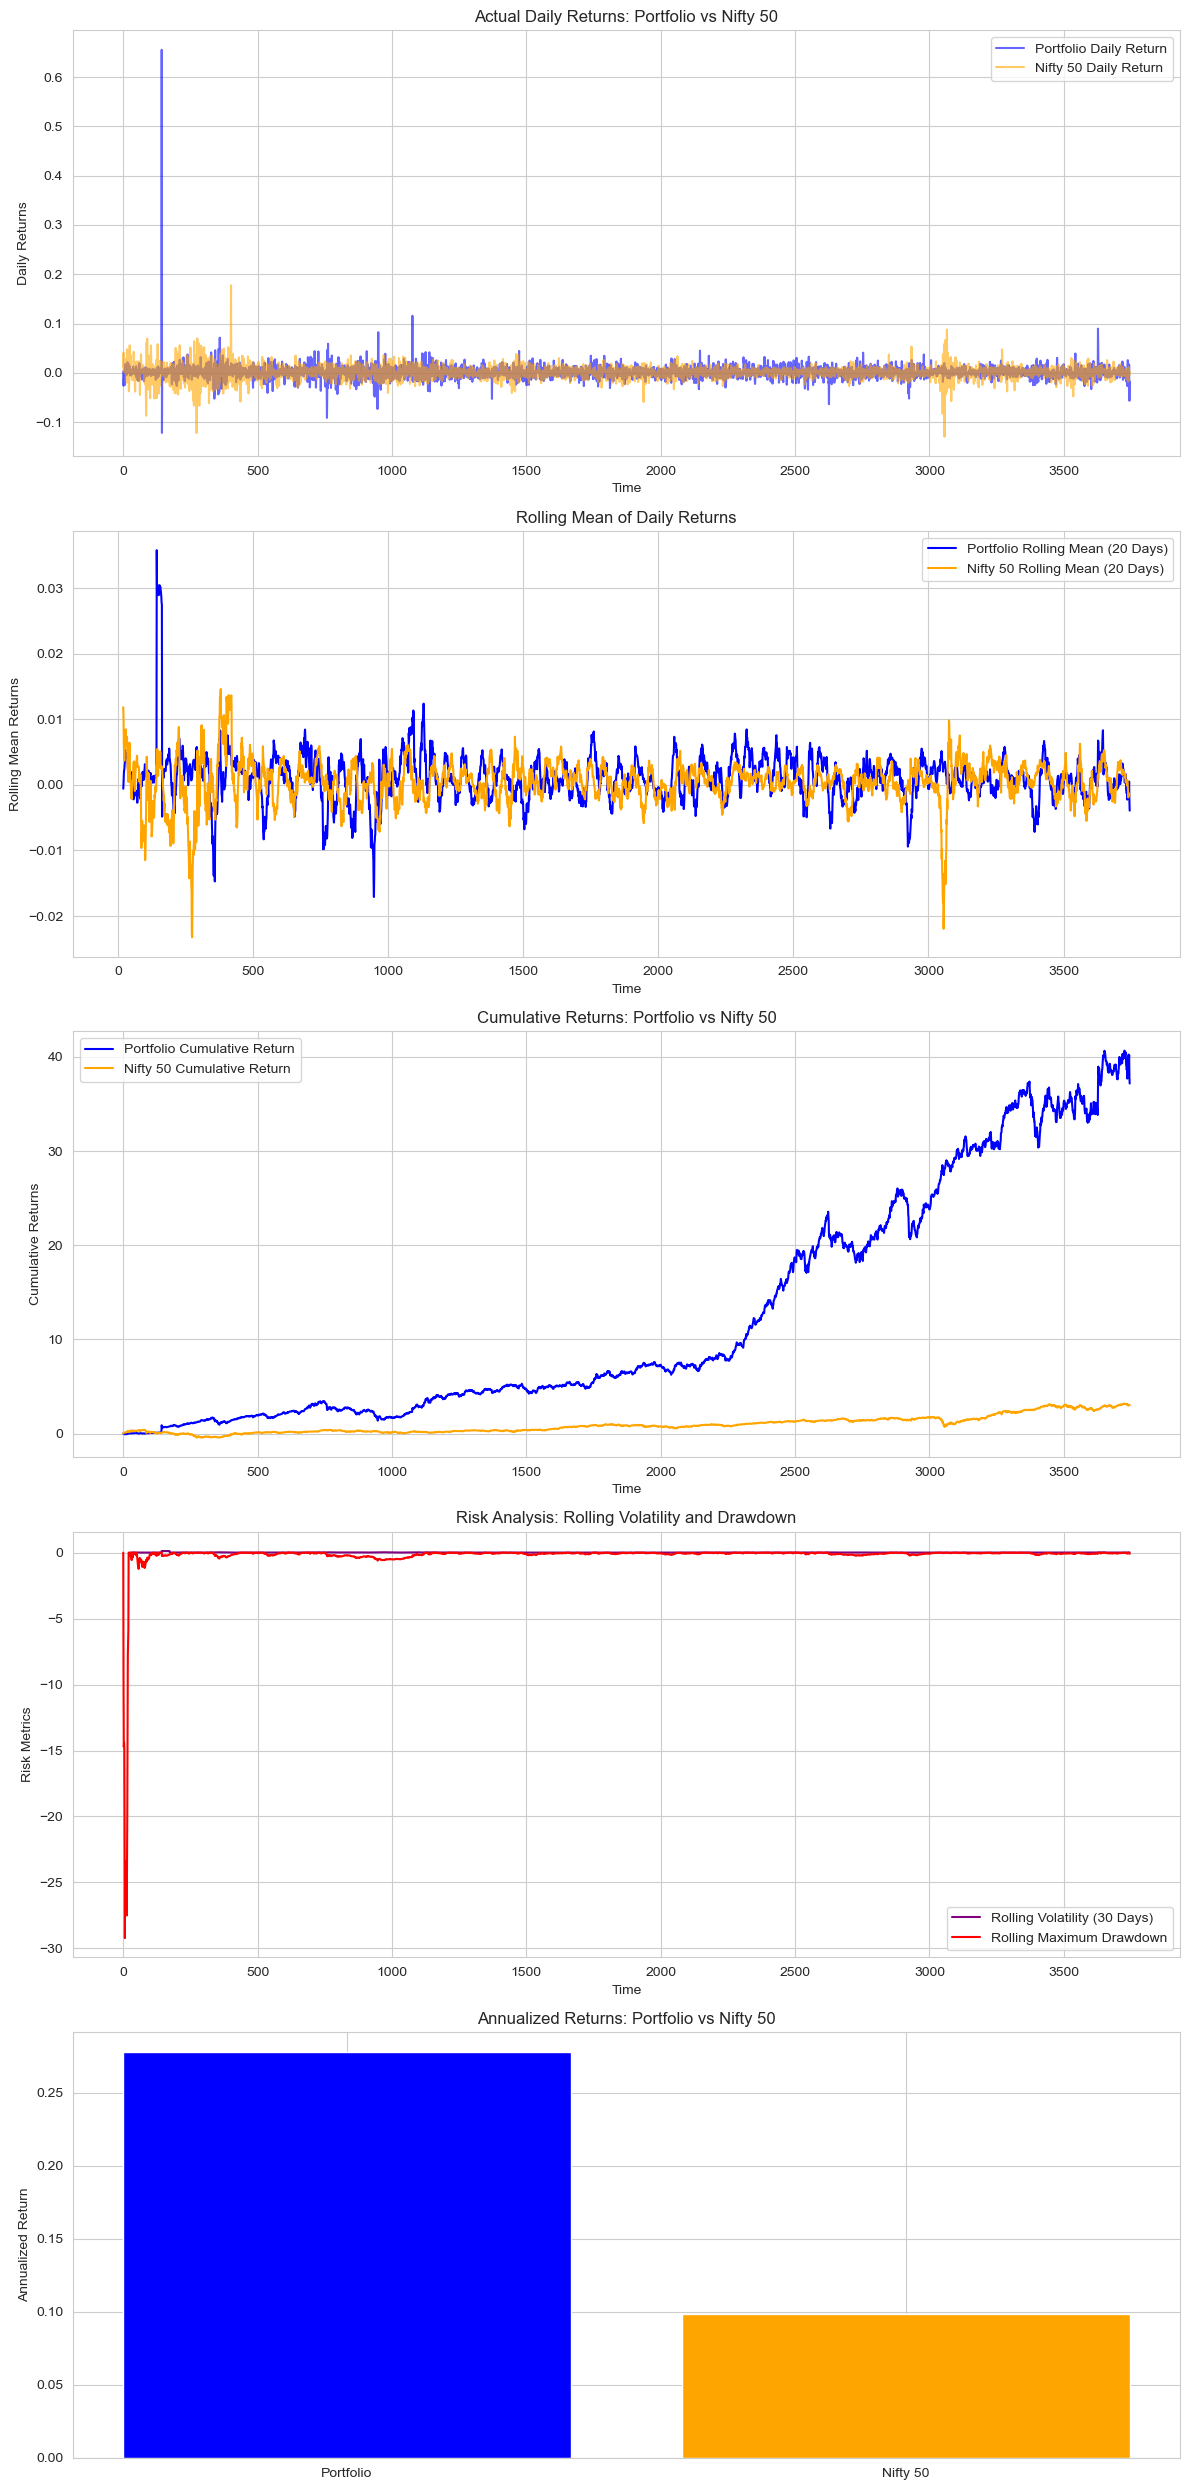

Annualized Sharpe Ratio for Portfolio: 0.9098
Portfolio Annualized Return: 0.2776
Nifty 50 Annualized Return: 0.0983


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

def backtest_portfolio_with_benchmark(data_folder, portfolio_weights_file, nifty_data_file, feature_column='Close', transaction_cost=0, rolling_window=20, risk_free_rate=0.04, extreme_threshold=1000):
    # Gather all stock data files in the folder
    stock_data_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
    portfolio_weights = pd.read_csv(portfolio_weights_file, header=None)

    # Ensure portfolio_weights has the correct number of columns (matching stock data files)
    if portfolio_weights.shape[1] != len(stock_data_files):
        raise ValueError(f"Portfolio weights file has {portfolio_weights.shape[1]} columns, "
                         f"but there are {len(stock_data_files)} stock data files. Please check the data files.")
    
    # Read stock returns
    stock_returns_list = []
    for file in stock_data_files:
        stock_data = pd.read_csv(file)
        stock_returns = stock_data[feature_column].pct_change().dropna()
        stock_returns_list.append(stock_returns.values)

    # Load Nifty data and calculate returns
    nifty_data = pd.read_csv(nifty_data_file)
    nifty_returns = nifty_data[feature_column].pct_change().dropna().values

    # Calculate min_length across portfolio_weights, stock_returns, and nifty_returns
    min_length = min(len(r) for r in stock_returns_list + [portfolio_weights, nifty_returns])

    # Truncate all arrays to min_length to ensure consistent lengths
    stock_returns = np.array([r[:min_length] for r in stock_returns_list]).T
    portfolio_weights = portfolio_weights.values[:min_length, :]
    nifty_returns = nifty_returns[:min_length]

    # Identify and remove rows with extreme weights, then filter all arrays to maintain alignment
    extreme_rows = (np.abs(portfolio_weights) > extreme_threshold).any(axis=1)

    # Filter the arrays based on extreme_rows
    filtered_weights = portfolio_weights[~extreme_rows]
    filtered_returns = stock_returns[~extreme_rows]
    filtered_nifty_returns = nifty_returns[~extreme_rows]


    # Ensure portfolio weights sum to 1 for each timestep
    filtered_weights = filtered_weights / np.clip(filtered_weights.sum(axis=1, keepdims=True), 1e-6, None)
    portfolio_returns = np.sum(filtered_returns * filtered_weights, axis=1)

    # Apply transaction costs for rebalancing
    for i in range(1, len(portfolio_returns)):
        rebalance_cost = transaction_cost * np.sum(np.abs(filtered_weights[i] - filtered_weights[i-1]))
        portfolio_returns[i] -= rebalance_cost

    # Calculate cumulative returns for portfolio
    portfolio_cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
    nifty_cumulative_returns = np.cumprod(1 + filtered_nifty_returns) - 1

    # Rolling metrics and Sharpe ratio calculation
    rolling_portfolio_returns = pd.Series(portfolio_returns).rolling(window=rolling_window).mean()
    rolling_nifty_returns = pd.Series(filtered_nifty_returns).rolling(window=rolling_window).mean()
    sharpe_ratio = (np.mean(portfolio_returns) * 252 - risk_free_rate) / (np.std(portfolio_returns) * np.sqrt(252))

    # Volatility, drawdown, and annualized returns calculations
    rolling_volatility = pd.Series(portfolio_returns).rolling(window=30).std()
    rolling_max = np.maximum.accumulate(portfolio_cumulative_returns)
    rolling_drawdown = (portfolio_cumulative_returns - rolling_max) / rolling_max
    portfolio_annualized_return = np.prod(1 + portfolio_returns) ** (252 / len(portfolio_returns)) - 1
    nifty_annualized_return = np.prod(1 + filtered_nifty_returns) ** (252 / len(filtered_nifty_returns)) - 1

    # Visualization setup with seaborn
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(5, 1, figsize=(12, 25))

    # Plot 1: Daily Returns
    ax[0].plot(portfolio_returns, label="Portfolio Daily Return", color='blue', alpha=0.6)
    ax[0].plot(filtered_nifty_returns, label="Nifty 50 Daily Return", color='orange', alpha=0.6)
    ax[0].set_title("Actual Daily Returns: Portfolio vs Nifty 50")
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Daily Returns')
    ax[0].legend()
    ax[0].grid(True)
    
    # Plot 2: Rolling Mean of Returns
    ax[1].plot(rolling_portfolio_returns, label=f"Portfolio Rolling Mean ({rolling_window} Days)", color='blue')
    ax[1].plot(rolling_nifty_returns, label=f"Nifty 50 Rolling Mean ({rolling_window} Days)", color='orange')
    ax[1].set_title("Rolling Mean of Daily Returns")
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Rolling Mean Returns')
    ax[1].legend()
    ax[1].grid(True)
    
    # Plot 3: Cumulative Returns
    ax[2].plot(portfolio_cumulative_returns, label="Portfolio Cumulative Return", color='blue')
    ax[2].plot(nifty_cumulative_returns, label="Nifty 50 Cumulative Return", color='orange')
    ax[2].set_title("Cumulative Returns: Portfolio vs Nifty 50")
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('Cumulative Returns')
    ax[2].legend()
    ax[2].grid(True)

    # Plot 4: Risk Analysis (Rolling Volatility and Drawdown)
    ax[3].plot(rolling_volatility, label="Rolling Volatility (30 Days)", color='purple')
    ax[3].plot(rolling_drawdown, label="Rolling Maximum Drawdown", color='red')
    ax[3].set_title("Risk Analysis: Rolling Volatility and Drawdown")
    ax[3].set_xlabel("Time")
    ax[3].set_ylabel("Risk Metrics")
    ax[3].legend()
    ax[3].grid(True)

    # Plot 5: Annualized Returns
    ax[4].bar(["Portfolio", "Nifty 50"], [portfolio_annualized_return, nifty_annualized_return], color=['blue', 'orange'])
    ax[4].set_title("Annualized Returns: Portfolio vs Nifty 50")
    ax[4].set_ylabel("Annualized Return")
    ax[4].grid(True)

    plt.tight_layout()
    plt.show()
    
    # Print key metrics
    print(f"Annualized Sharpe Ratio for Portfolio: {sharpe_ratio:.4f}")
    print(f"Portfolio Annualized Return: {portfolio_annualized_return:.4f}")
    print(f"Nifty 50 Annualized Return: {nifty_annualized_return:.4f}")
    
    return portfolio_cumulative_returns, nifty_cumulative_returns

# File paths for your data
#data_folder = r'/Users/pranayvij/MTP-Work/data'
data_folder = r'C:\Users\Kartik\MTP-Work\data'
#portfolio_weights_file = r'/Users/pranayvij/MTP-Work/results/portfolio_weights_full.csv'
portfolio_weights_file = r'C:\Users\Kartik\MTP-Work\results\portfolio_weights_full.csv'
#nifty_data_file = r'/Users/pranayvij/MTP-Work/^NSEI.csv'
nifty_data_file = r'C:\Users\Kartik\MTP-Work\^NSEI.csv'



# Execute backtesting function
portfolio_cumulative_returns, nifty_cumulative_returns = backtest_portfolio_with_benchmark(
    data_folder, portfolio_weights_file, nifty_data_file, transaction_cost=0.01
)
